## Imports

In [19]:
!echo $CUDA_VISIBLE_DEVICES

0,1


In [20]:
import torch

In [21]:
# DEVICE = torch.device('cpu')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

## Load data

In [22]:
%run ../datasets/__init__.py

In [23]:
dataset_kwargs = {
    'dataset_name': 'cxr14',  # 'covid-x',
    'max_samples': None,
    'labels': ['Cardiomegaly'],
}
dataloader = prepare_data_classification(dataset_type='train', **dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

Loading cxr14/train dataset...


75714

In [24]:
COVID_SAMPLES = [idx for idx, presence in dataset.get_labels_presence_for('covid') if presence]
len(COVID_SAMPLES)

KeyError: 'covid'

## Load model

In [25]:
%run ../models/checkpoint/__init__.py

In [26]:
# run_name = '0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid'
# run_name = '0714_030324_covid-x_resnet-50_lr1e-06_os-max14'
# run_name = '0721_214907_cxr14_densenet-121_lr0.001_aug-0_bce_Cardiomegaly_size256'
# run_name = '0721_124730_cxr14_densenet-121_lr1e-05_bce_Cardiomegaly_size256'
run_name = '1215_174443_cxr14_resnet-50-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1'
debug = False

In [27]:
compiled_model = load_compiled_model_classification(run_name, debug, DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'resnet-50-v2',
  'labels': ['Cardiomegaly'],
  'imagenet': True,
  'freeze': False,
  'gpool': 'avg',
  'fc_layers': []},
 'opt_kwargs': {'lr': 0.0001},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.1,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_name': 'wbce', 'loss_kwargs': {}, 'batch_size': 140},
 'other_train_kwargs': {'early_stopping': True,
  'early_stopping_kwargs': {'patience': 10,
   'metric': 'roc_auc',
   'min_delta': 0},
  'lr_sch_metric': 'roc_auc'},
 'dataset_kwargs': {'dataset_name': 'cxr14',
  'labels': ['Cardiomegaly'],
  'max_samples': None,
  'batch_size': 140,
  'image_size': [256, 256],
  'frontal_only': False,
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None,
  'oversample': True,
  'oversample_label': 0,
  'oversample_class': None,
  'oversample_ratio': None,
  'oversample_max_ratio': None,
  'augment': False,
  'augment_label': None,
  'augment_class'

In [28]:
model = compiled_model.model
_ = model.eval()

In [29]:
model.features[-1][-1].relu

ReLU(inplace=True)

## Apply Grad-CAM

In [30]:
from torch import nn
import captum
from captum.attr import LayerGradCam, GuidedGradCam, visualization

from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

In [31]:
mpl.rcParams['figure.facecolor'] = 'white'

In [32]:
%run ../utils/common.py

In [34]:
from torch.nn.functional import softmax
from torch import sigmoid

In [35]:
class Wrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        output = self.model(x)[0]
        # output = softmax(output, dim=-1)
        output = sigmoid(output)
        return output

In [36]:
wrapped_model = Wrapper(model)

In [37]:
# forward_fn = lambda inputs: model(inputs)[0]
# layer = model.features.denseblock4.denselayer16.conv1
#layer = model.base_cnn.features.conv0
# layer = model.base_cnn.layer4
# layer = model.base_cnn.features.denseblock4
layer = model.features[-1][-1].relu

grad_cam = LayerGradCam(wrapped_model, layer)
# grad_cam = GuidedGradCam(Dummy(model), layer)

In [38]:
dataset.multilabel

True

In [39]:
def plot_cam(idx, manual_norm=True, **kwargs):
    # image, label = dataset[idx]
    sample = dataset[idx]
    image = sample[0]
    label = sample[1]

    images = image.unsqueeze(0).to(DEVICE)

    output = model(images)[0].detach().squeeze(0)
    print('Label:', label)
    if dataset.multilabel:
        print('Prediction: ', output)
        label = 0 # label[0]
        # print(label)
    else:
        print('Prediction: ', softmax(output, dim=-1))

    attributions = grad_cam.attribute(images, label) # relu_attributions=False
    attributions = attributions.detach().cpu().squeeze(0).squeeze(0)
    attributions = attributions.numpy()
    
    print('Stats: ', attributions.min(), attributions.max())
    
    if manual_norm:
        attributions = arr_to_range(attributions)
        print('Normalizing... ', attributions.min(), attributions.max())

    image_color = image.detach().permute(1, 2, 0).cpu().numpy()
    image_color = arr_to_range(image_color)

    attrs_color = gray2rgb(attributions)
    attrs_color = resize(attrs_color, image_color.shape)

    visualization.visualize_image_attr_multiple(attrs_color,
                                                image_color,
                                                methods=['original_image',
                                                         'blended_heat_map'],
                                                signs=['all', 'all'],
                                               )
    
    return attrs_color

Label: [0]
Prediction:  tensor([-8.6299], device='cuda:0')
Stats:  -3.0088831e-05 6.815497e-06
Normalizing...  0.0 1.0


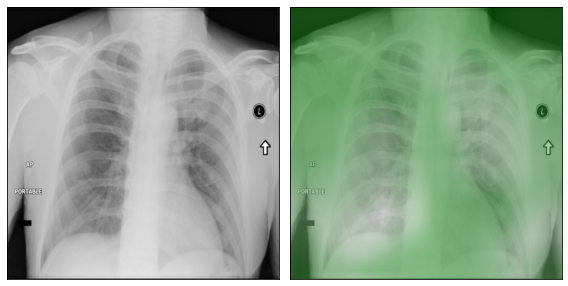

In [41]:
attrs = plot_cam(4, show_colorbar=True, cmap='jet')

In [167]:
mins = []
maxs = []

for idx in tqdm(COVID_SAMPLES): # range(100) # len(dataset)
    image, label = dataset[idx]
    images = image.unsqueeze(0).to(DEVICE)

    attributions = grad_cam.attribute(images, 0)
    attributions = attributions.detach().cpu().squeeze(0).squeeze(0)
    attributions = attributions.numpy()

    mins.append(attributions.min())
    maxs.append(attributions.max())
    
np.mean(mins), np.mean(maxs)

(-2.0381943e-10, 2.047288e-10)

In [ ]:
0: (-2.0381943e-10, 2.047288e-10)
1: (-2.1670395e-10, 2.1722059e-10)
2: (-2.0727114e-10, 2.0217203e-10)